In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder

 # 1. Получение и загрузка данных

In [2]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

# 2. Удаление пропусков и категориальных переменных из тренировочного набора

In [3]:
train_data_cleaned = train_data.dropna()
train_data_cleaned = train_data_cleaned.select_dtypes(exclude=['object'])

# 3. Обучение модели и выбор метрики качества


In [21]:
X_train = train_data_cleaned.drop('Survived', axis=1)
y_train = train_data_cleaned['Survived']

X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

model = RandomForestClassifier()
model.fit(X_train_split, y_train_split)
y_pred = model.predict(X_test_split)

accuracy_original = accuracy_score(y_test_split, y_pred)
print(f'Accuracy на исходных данных: {accuracy_original:.2f}')

Accuracy на исходных данных: 0.70


# 4. Удаление лишних признаков

In [5]:
train_data_full = train_data.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1)
test_data_full = test_data.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1)

# 5. Проверка данных на пропущенные значения

In [6]:
missing_train = train_data_full.isnull().sum()
missing_test = test_data_full.isnull().sum()
print(f'Пропущенные значения в тренировочном наборе:\n{missing_train[missing_train > 0]}')
print(f'Пропущенные значения в тестовом наборе:\n{missing_test[missing_test > 0]}')

Пропущенные значения в тренировочном наборе:
Age         177
Embarked      2
dtype: int64
Пропущенные значения в тестовом наборе:
Age     86
Fare     1
dtype: int64


In [7]:
# a) Посчитайте, какой процент данных будет потерян, если просто удалить пропуски
percent_missing_train = missing_train / len(train_data_full) * 100
percent_missing_test = missing_test / len(test_data_full) * 100
print(f'Процент пропущенных значений в тренировочном наборе:\n{percent_missing_train[percent_missing_train > 0]}')
print(f'Процент пропущенных значений в тестовом наборе:\n{percent_missing_test[percent_missing_test > 0]}')

Процент пропущенных значений в тренировочном наборе:
Age         19.865320
Embarked     0.224467
dtype: float64
Процент пропущенных значений в тестовом наборе:
Age     20.574163
Fare     0.239234
dtype: float64


In [8]:
# b) Заполните пропуски
train_data_full['Age'].fillna(train_data_full['Age'].mean(), inplace=True)  # Заполнение средним
train_data_full['Embarked'].fillna('S', inplace=True)  # Заполнение константой
test_data_full['Age'].fillna(test_data_full['Age'].mean(), inplace=True)  # Заполнение средним
test_data_full['Fare'].fillna(test_data_full['Fare'].median(), inplace=True)  # Заполнение медианой

<ipython-input-8-9b256de60182>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_data_full['Age'].fillna(train_data_full['Age'].mean(), inplace=True)  # Заполнение средним
<ipython-input-8-9b256de60182>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing '

# 6. Категориальные переменные переведите в цифровые значения


In [9]:
train_data_full = pd.get_dummies(train_data_full, drop_first=True)
test_data_full = pd.get_dummies(test_data_full, drop_first=True)

# 7. Проверьте данные на наличие выбросов

In [11]:
# Используем метод IQR для определения выбросов только для числовых столбцов
numeric_columns = train_data_full.select_dtypes(include=[np.number]).columns
Q1_train = train_data_full[numeric_columns].quantile(0.25)
Q3_train = train_data_full[numeric_columns].quantile(0.75)
IQR_train = Q3_train - Q1_train
# Удаляем выбросы
train_data_no_outliers = train_data_full[~((train_data_full[numeric_columns] < (Q1_train - 1.5 * IQR_train)) |
                                            (train_data_full[numeric_columns] > (Q3_train + 1.5 * IQR_train))).any(axis=1)]

# 8. Визуализация распределения возраста

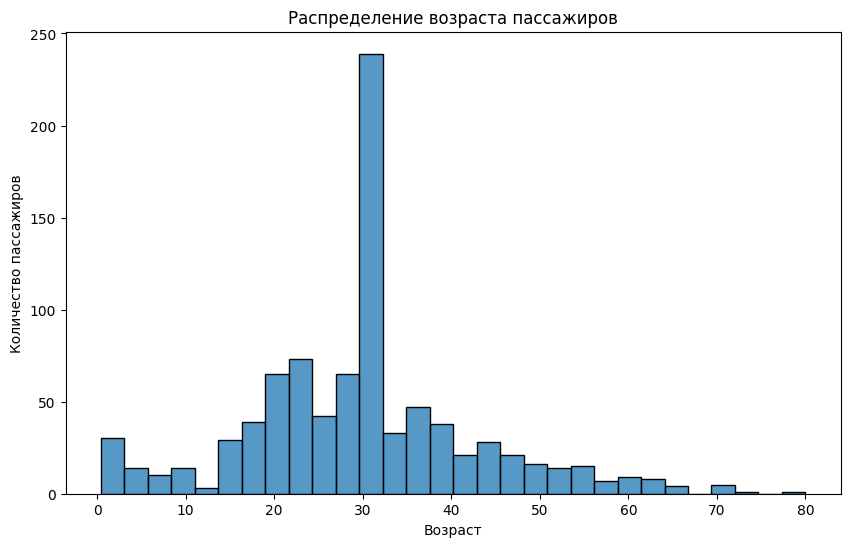

In [12]:
plt.figure(figsize=(10, 6))
sns.histplot(train_data_full['Age'], bins=30)  # График распределения возраста
plt.title('Распределение возраста пассажиров')
plt.xlabel('Возраст')
plt.ylabel('Количество пассажиров')
plt.show()

# 9. Математическое преобразование признака Age


In [13]:
train_data_full['Age'] = np.log(train_data_full['Age'] + 1)  # Преобразование Age
test_data_full['Age'] = np.log(test_data_full['Age'] + 1)  # Преобразование Age в тестовом наборе

# 10. Обучение модели на преобразованных данных

In [20]:
# Обучаем модель на преобразованных данных
model_final = RandomForestClassifier()
model_final.fit(X_train_final, y_train_final)
# Предсказание на тестовом наборе
y_pred_final = model_final.predict(X_train_final)
# Вычисляем метрику качества на преобразованных данных
accuracy_transformed = accuracy_score(y_train_final, y_pred_final)
print(f'Accuracy на преобразованных данных: {accuracy_transformed:.2f}')


Accuracy на преобразованных данных: 0.98


# 11. Сравните метрики

In [22]:
print("Сравнение метрик:")
print(f"Accuracy на исходных данных: {accuracy_original:.2f}")
print(f"Accuracy на преобразованных данных: {accuracy_transformed:.2f}")

Сравнение метрик:
Accuracy на исходных данных: 0.70
Accuracy на преобразованных данных: 0.98


# Выводы

In [24]:
print(f"a) Преобразования: заполнение пропусков, преобразование Age с использованием логарифмической функции.")
print(f"b) Сравнение метрик: Accuracy на исходных данных: {accuracy_original:.2f}, на преобразованных данных: {accuracy_transformed:.2f}.")
print("c) Работа с данными важна для построения качественных моделей. На примере данной работы, видно что обработка данных перед обучением модели, значительно улучшает показатель точности. Аналогично следует исследовать и дополнять большие данные.")

a) Преобразования: заполнение пропусков, преобразование Age с использованием логарифмической функции.
b) Сравнение метрик: Accuracy на исходных данных: 0.70, на преобразованных данных: 0.98.
c) Работа с данными важна для построения качественных моделей. На примере данной работы, видно что обработка данных перед обучением модели, значительно улучшает показатель точности. Аналогично следует исследовать и дополнять большие данные.
